In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/Face-Mask-Detection-master.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [15]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"/content/Face-Mask-Detection-master/dataset"
CATEGORIES = ["with_mask", "without_mask"]
print("[INFO] loading images...")
data = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image=load_img(img_path,target_size=(224,224))
        image=img_to_array(image)
        image=preprocess_input(image)
        data.append(image)
        labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data, dtype="float32")
labels = np.array(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

aug=ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")





[INFO] loading images...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [16]:
#load the mobileNetV2 network,ensuring the head FC layer  sets are
#left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))




<ipython-input-16-aa5f32b9dd9a>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
#construct the head of the model that will be placed on the top
#of the base
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [18]:
#here we place the head Fc model on top of the base model
#this will be the actual model that we will use
model = Model(inputs=baseModel.input, outputs=headModel)
#loop over all layers in the base model and freeze them
#so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


In [24]:
#compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS) # Changed 'Lr' to 'lr'
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [27]:
#train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=aug.flow(testX, testY, batch_size=BS), # Apply the same augmentation to test data
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

[INFO] training head...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 45s 447ms/step - accuracy: 0.9704 - loss: 0.1172 - val_accuracy: 0.9783 - val_loss: 0.0623
Epoch 2/20
 1/95 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 1.0000 - loss: 0.0251

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 1.0000 - val_loss: 0.0293
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.9784 - loss: 0.0814 - val_accuracy: 0.9878 - val_loss: 0.0470
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9688 - loss: 0.0788 - val_accuracy: 1.0000 - val_loss: 0.0238
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - accuracy: 0.9808 - loss: 0.0775 - val_accuracy: 0.9878 - val_loss: 0.0487
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0283 - val_accuracy: 0.9355 - val_loss: 0.1077
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 512ms/step - accuracy: 0.9840 - loss: 0.0623 - val_accuracy: 0.9851 - val_loss: 0.0400
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0439
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - accuracy: 0.9840 - loss: 0.0578 - val_accuracy: 0.9878 - val_los

In [30]:
#make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [31]:
#for each image in the image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [32]:
#show a niicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.97      1.00      0.98       383
without_mask       1.00      0.97      0.98       384

    accuracy                           0.98       767
   macro avg       0.98      0.98      0.98       767
weighted avg       0.98      0.98      0.98       767



In [34]:
#serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model.h5")

[INFO] saving mask detector model...


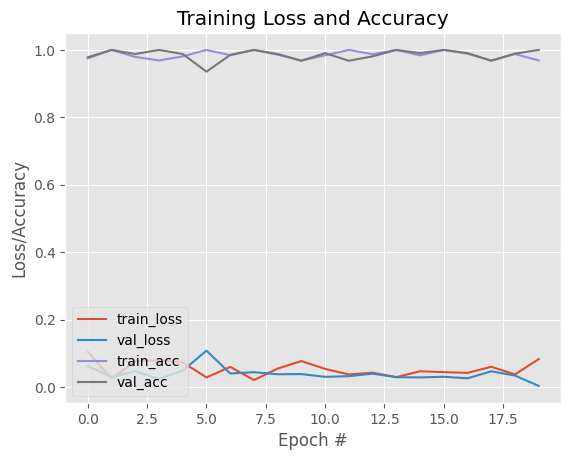

In [36]:
#plot the training loss and accuracy
N=EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),H.history["val_accuracy"],label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Mask (100.00%)


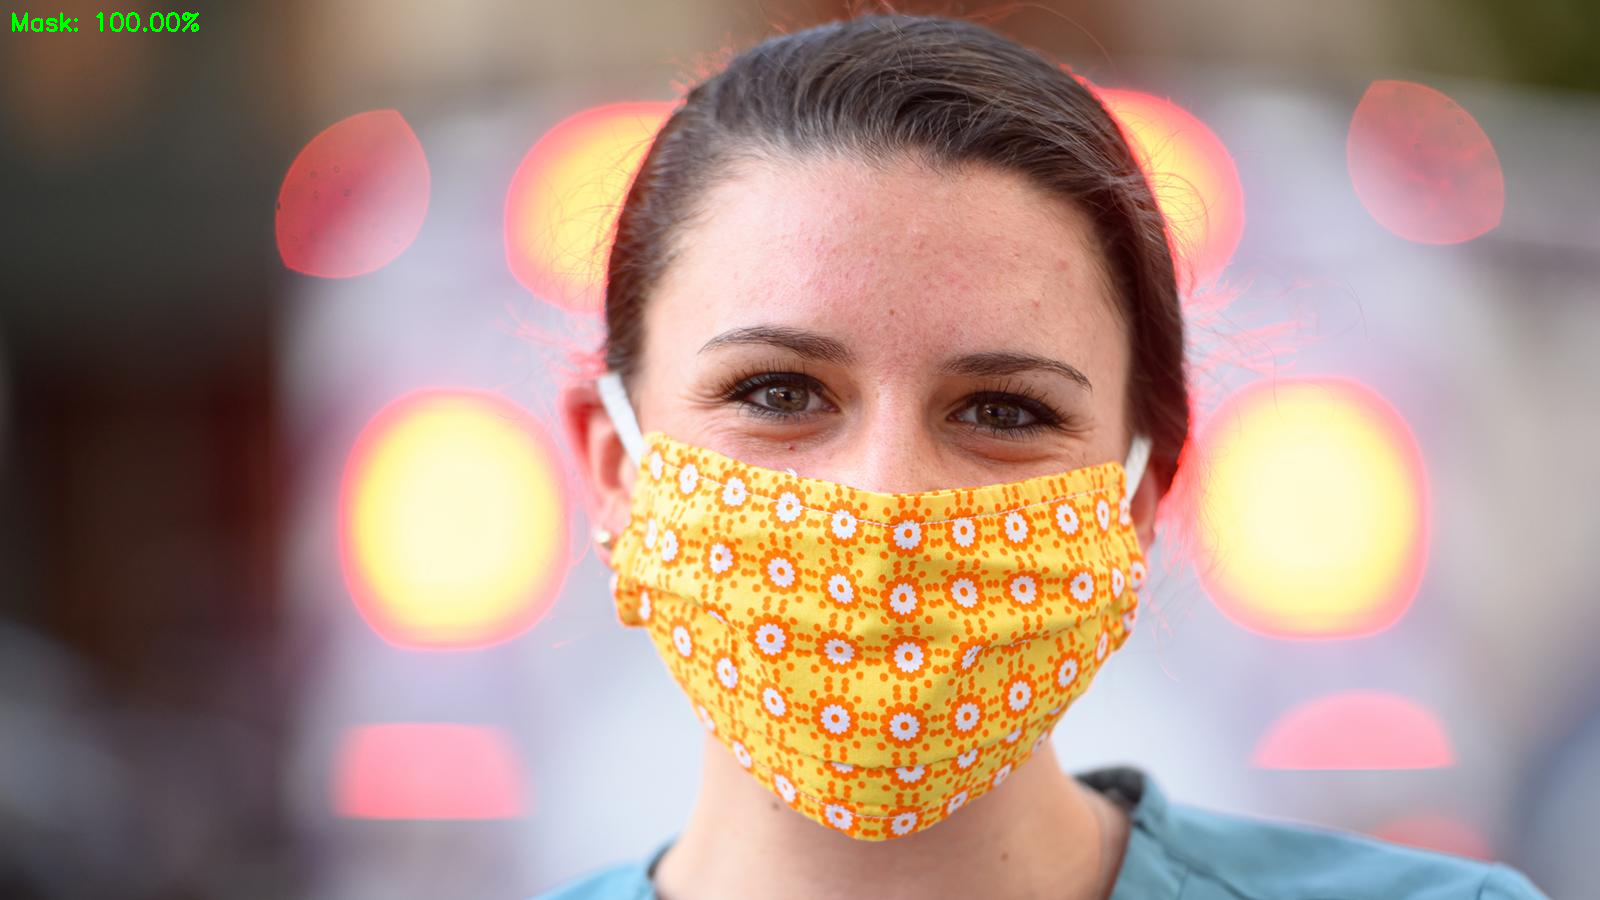

In [113]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#Import the cv2_imshow function from google.colab.patches
from google.colab.patches import cv2_imshow

# Load the trained face mask detector model
model = load_model("/content/mask_detector.model.h5")

# Function to preprocess the input image for prediction
def prepare_image(image_path):
    # Load the input image and convert it to a NumPy array, then preprocess it
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize to match input shape of model
    image = img_to_array(image)
    image = preprocess_input(image)  # Preprocess using MobileNetV2-specific method
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Provide the path to the image you want to test
image_path = "/content/p08c7jft.jpg"

# Preprocess the image
test_image = prepare_image(image_path)

# Make a prediction on the image
(prediction_mask, prediction_no_mask) = model.predict(test_image)[0]

# Determine the label based on the predictions
label = "Mask" if prediction_mask > prediction_no_mask else "No Mask"
probability = max(prediction_mask, prediction_no_mask) * 100

# Output the result
print(f"Prediction: {label} ({probability:.2f}%)")

# Optionally display the image with the predicted label
image = cv2.imread(image_path)
label_text = f"{label}: {probability:.2f}%"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

# Add the label to the image
cv2.putText(image, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
#Use cv2_imshow instead of cv2.imshow
cv2_imshow(image)

# Press any key to close the image window
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: No Mask (100.00%)


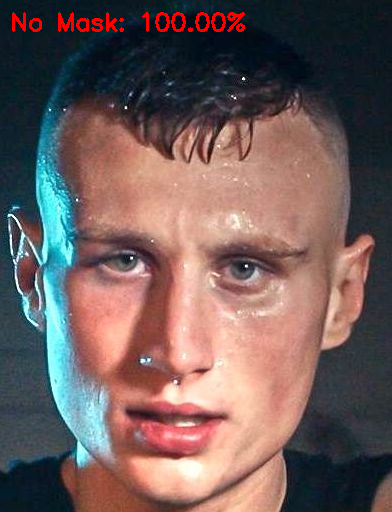

In [114]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#Import the cv2_imshow function from google.colab.patches
from google.colab.patches import cv2_imshow

# Load the trained face mask detector model
model = load_model("/content/mask_detector.model.h5")

# Function to preprocess the input image for prediction
def prepare_image(image_path):
    # Load the input image and convert it to a NumPy array, then preprocess it
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Resize to match input shape of model
    image = img_to_array(image)
    image = preprocess_input(image)  # Preprocess using MobileNetV2-specific method
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Provide the path to the image you want to test
image_path = "/content/Ryan_Hearst.jpg"

# Preprocess the image
test_image = prepare_image(image_path)

# Make a prediction on the image
(prediction_mask, prediction_no_mask) = model.predict(test_image)[0]

# Determine the label based on the predictions
label = "Mask" if prediction_mask > prediction_no_mask else "No Mask"
probability = max(prediction_mask, prediction_no_mask) * 100

# Output the result
print(f"Prediction: {label} ({probability:.2f}%)")

# Optionally display the image with the predicted label
image = cv2.imread(image_path)
label_text = f"{label}: {probability:.2f}%"
color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

# Add the label to the image
cv2.putText(image, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
#Use cv2_imshow instead of cv2.imshow
cv2_imshow(image)

# Press any key to close the image window
cv2.waitKey(0)
cv2.destroyAllWindows()